In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel

def compute_and_save_embeddings_to_csv(image_directory, csv_output_file):
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    data = []

    for filename in os.listdir(image_directory):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(image_directory, filename)
            image = Image.open(image_path)
            print(f"Processing {image_path}")
            inputs = processor(images=image, return_tensors="pt")
            
            with torch.no_grad():
                image_features = model.get_image_features(**inputs)
            
            # Flatten the embeddings to a list
            embeddings = image_features.cpu().numpy().flatten().tolist()
            
            # Append the data
            data.append([filename, embeddings])
    
    # Create a DataFrame and save to CSV
    df = pd.DataFrame(data, columns=['image_file_name', 'embedding'])
    df.index.name = 'index'
    df.to_csv(csv_output_file, index=True)

# Example usage
image_directory = '/home/rz60/codes/COMP646/COMP646_Project/segments_pool'
csv_output_file = 'image_embeddings.csv'
compute_and_save_embeddings_to_csv(image_directory, csv_output_file)


/home/sl237/.conda/envs/ltsm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sl237/.conda/envs/ltsm/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2007_000170_bottle_0.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2008_003105_train_0.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2008_002473_car_0.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2007_003205_chair_1.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2009_003768_horse_0.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2011_002064_bicycle_1.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2008_000725_person_1.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2010_003409_person_0.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2008_000811_person_2.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2010_000238_person_0.png
Processing /home/rz60/codes/COMP646/COMP646_Project/segments_pool/2010_004805_chair_0.png
Proce

In [69]:
import pandas as pd
import numpy as np
from transformers import CLIPProcessor, CLIPModel
from scipy.spatial.distance import cosine
from PIL import Image
import ast  # For converting string representations of lists into lists

def load_embeddings_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    df['embedding'] = df['embedding'].apply(ast.literal_eval)
    return df

def load_prompt_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    return df['image_file_name']

def get_text_embedding(prompt, model, processor):
    inputs = processor(text=prompt, return_tensors="pt", padding=True)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features.cpu().numpy().flatten()

def find_top_similar_images(prompt, embeddings_df, model, processor, top_n=5):
    prompt_embedding = get_text_embedding(prompt, model, processor)

    similarities = []
    for img_emb in embeddings_df['embedding']:
        img_emb_array = np.array(img_emb).flatten()
        similarity = 1 - cosine(prompt_embedding, img_emb_array)
        similarities.append(similarity)

    top_indices = np.argsort(similarities)[::-1][:top_n]  # Get indices of top N similarities

    return embeddings_df.iloc[top_indices]['image_file_name'].tolist()


model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

csv_file = 'image_embeddings.csv'
embeddings_df = load_embeddings_from_csv(csv_file)
prompt = "A photo of a cat"

top_similar_images = find_top_similar_images(prompt, embeddings_df, model, processor, top_n=5)
print("Top 5 similar images are:", top_similar_images)




Top 5 similar images are: ['2008_004621_sheep_0.png', '2010_002973_cat_0.png', '2009_002527_cat_0.png', '2009_001391_cat_0.png', '2007_001825_cat_0.png']


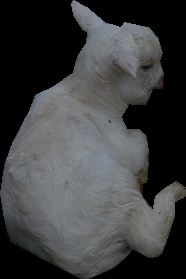

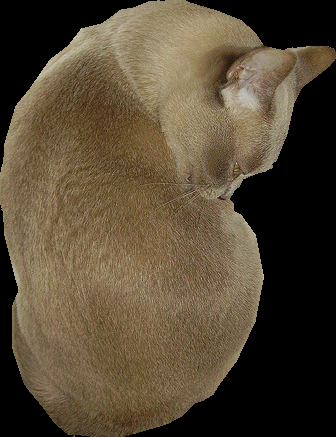

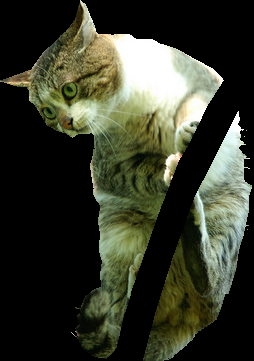

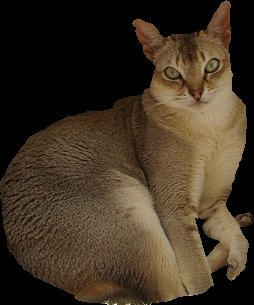

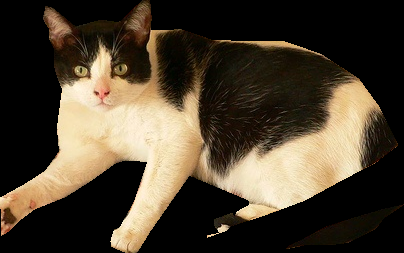

In [11]:
image_directory = '/home/rz60/codes/COMP646/COMP646_Project/segments_pool/'
for file_path in top_similar_images:
    image_path = image_directory + file_path
    image = Image.open(image_path)
    display(image)
    # image.show()
# image = image_directory+most_relevant_image_file
# image_path = image_directory + most_relevant_image_file
# image = Image.open(image_path)
# display(image)
# # image.show()


In [3]:
import os
s = "2007_003205_chair_1.png"
s.split("_")[2]

'chair'

In [82]:
import pandas as pd

csv_file = 'image_embeddings.csv'
def load_prompt_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    # df['image_file_name'].values.split("_")[2]
    prompts = ["a photo of a "+x.split("_")[2] for x in df['image_file_name'].values]
    return prompts

def load_embeddings_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    df['embedding'] = df['embedding'].apply(ast.literal_eval)
    return df


# def load_text_from_csv(csv_file):
#     df = pd.read_csv(csv_file)
#     return df['image_file_name']

def get_text_embedding(prompt, model, processor):
    inputs = processor(text=prompt, return_tensors="pt", padding=True)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features.cpu().numpy().flatten()

In [75]:
from transformers import CLIPProcessor, CLIPModel
from scipy.spatial.distance import cosine
import torch
import ast 
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_image_embedding(image, model, processor):
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.cpu().numpy().flatten()

def get_text_embedding(text, model, processor):
    inputs = processor(text=text, return_tensors="pt", padding=True)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features.cpu().numpy().flatten()

def calculate_clip_score(image_embedding, prompts):
    text_embedding = get_text_embedding(prompts, model, processor)
    # print(image_embedding.shape, text_embedding.shape)
    return 1 - cosine(image_embedding, text_embedding)

def evaluate_clip_score(images, prompts):
    scores = []
    for image, prompt in zip(images, prompts):
        score = calculate_clip_score(image, prompt)
        scores.append(score)
    return sum(scores) / len(scores)

# Example usage
csv_file = 'image_embeddings.csv'
image_embeddings = load_embeddings_from_csv(csv_file)
prompts = load_prompt_from_csv(csv_file)

average_clip_score = evaluate_clip_score(image_embeddings, list(prompts))

print(f"Average CLIP Score: {average_clip_score}")

Average CLIP Score: 0.26610906693676173


In [76]:
unique_prompts = list(set(prompts))


In [77]:
unique_prompts

['a photo of a tvmonitor',
 'a photo of a cat',
 'a photo of a person',
 'a photo of a boat',
 'a photo of a sofa',
 'a photo of a train',
 'a photo of a sheep',
 'a photo of a horse',
 'a photo of a cow',
 'a photo of a bottle',
 'a photo of a motorbike',
 'a photo of a car',
 'a photo of a chair',
 'a photo of a diningtable',
 'a photo of a bus',
 'a photo of a bird',
 'a photo of a aeroplane',
 'a photo of a bicycle',
 'a photo of a dog',
 'a photo of a pottedplant']

In [81]:
def find_top_similar_images(prompt, embeddings_df, model, processor, top_n=5):
    prompt_embedding = get_text_embedding(prompt, model, processor)

    similarities = []
    for img_emb in embeddings_df['embedding']:
        img_emb_array = np.array(img_emb).flatten()
        similarity = 1 - cosine(prompt_embedding, img_emb_array)
        similarities.append(similarity)

    top_indices = np.argsort(similarities)[::-1][:top_n]  # Get indices of top N similarities

    return embeddings_df.iloc[top_indices]['image_file_name'].tolist()

In [83]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

csv_file = 'image_embeddings.csv'
embeddings_df = load_embeddings_from_csv(csv_file)

total_accuracy = 0
for prompt in unique_prompts:
    top_similar_images = find_top_similar_images(prompt, embeddings_df, model, processor, top_n=5)
    class_name = prompt.split(" ")[-1]
    print("Top 5 similar images are:", top_similar_images)
    print(f"Class name: {class_name}")
    
    accuracy = 0
    accuracy = sum([1 for x in top_similar_images if class_name in x])/5
    total_accuracy += accuracy
    print(f"Accuracy for {class_name}: {accuracy}")
print(f"Total Accuracy: {total_accuracy/len(unique_prompts)}")

# top_similar_images = find_top_similar_images(prompt, embeddings_df, model, processor, top_n=5)
# print("Top 5 similar images are:", top_similar_images)

Top 5 similar images are: ['2007_000039_tvmonitor_0.png', '2007_001430_tvmonitor_0.png', '2010_002097_tvmonitor_1.png', '2008_001997_tvmonitor_1.png', '2008_004097_tvmonitor_0.png']
Class name: tvmonitor
Accuracy for tvmonitor: 1.0
Top 5 similar images are: ['2008_004621_sheep_0.png', '2010_002973_cat_0.png', '2009_002527_cat_0.png', '2009_001391_cat_0.png', '2007_001825_cat_0.png']
Class name: cat
Accuracy for cat: 0.8
Top 5 similar images are: ['2007_009684_person_0.png', '2007_005845_person_0.png', '2009_002372_person_0.png', '2009_001615_person_0.png', '2010_005353_bird_0.png']
Class name: person
Accuracy for person: 0.8
Top 5 similar images are: ['2008_000120_boat_0.png', '2010_000887_boat_0.png', '2008_006065_boat_0.png', '2008_000567_boat_0.png', '2007_000837_boat_0.png']
Class name: boat
Accuracy for boat: 1.0
Top 5 similar images are: ['2009_001146_sofa_0.png', '2011_001005_sofa_0.png', '2009_000487_sofa_0.png', '2009_004091_sofa_0.png', '2011_002953_sofa_0.png']
Class name: s

In [64]:
len(prompts), len(image_embeddings)

(3204, 3204)

In [51]:
# prompts = load_prompt_from_csv(csv_file)

In [55]:
up = prompts.unique()

In [67]:
up

array(['2007_000170_bottle_0.png', '2008_003105_train_0.png',
       '2008_002473_car_0.png', ..., '2010_000639_pottedplant_0.png',
       '2008_003333_person_0.png', '2010_001024_person_1.png'],
      dtype=object)

In [54]:
up.shape

(3204,)

In [34]:
list(prompts)

['2007_000170_bottle_0.png',
 '2008_003105_train_0.png',
 '2008_002473_car_0.png',
 '2007_003205_chair_1.png',
 '2009_003768_horse_0.png',
 '2011_002064_bicycle_1.png',
 '2008_000725_person_1.png',
 '2010_003409_person_0.png',
 '2008_000811_person_2.png',
 '2010_000238_person_0.png',
 '2010_004805_chair_0.png',
 '2008_007165_cat_0.png',
 '2007_001901_chair_0.png',
 '2011_002873_cow_2.png',
 '2007_004810_person_3.png',
 '2007_005759_motorbike_0.png',
 '2011_002863_bottle_0.png',
 '2011_000112_bird_1.png',
 '2008_003373_bus_0.png',
 '2008_007165_cat_1.png',
 '2008_006216_person_0.png',
 '2011_001810_sheep_1.png',
 '2009_001565_bird_0.png',
 '2007_005173_person_2.png',
 '2008_003676_pottedplant_2.png',
 '2011_001519_person_0.png',
 '2010_003634_chair_0.png',
 '2011_002932_bus_1.png',
 '2008_004892_person_6.png',
 '2008_002719_aeroplane_0.png',
 '2011_000239_bus_0.png',
 '2010_006026_sheep_1.png',
 '2010_003899_boat_1.png',
 '2011_001902_bird_0.png',
 '2007_007341_aeroplane_0.png',
 '2010_

In [38]:
res = get_text_embedding(prompts[0], model, processor)

In [40]:
res.shape

(512,)

In [35]:
inputs = processor(text=list(prompts), return_tensors="pt", padding=True)


In [37]:
inputs.input_ids.shape, inputs.attention_mask.shape

(torch.Size([3204, 21]), torch.Size([3204, 21]))

In [ ]:
average_clip_score = evaluate_clip_score(image_embeddings, prompts)